# Module 6: CFA
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

In this example, we aim to predict bad consumer credits, and we develop a classification model for this purpose, driven by loan and debtor attributes. We would use this model to accept or reject a customer’s business.

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
# import the main packages we will need
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

In [2]:
# We may have to install shap, an explainable AI (XAI) package onto your machine (or your Google Colab session if you are running this notebook in Colabl)
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 17.9 MB/s 


In [3]:
# Clone the FinGov repo which has key utility functions for this notebook
!git clone https://github.com/danphilps/FinGov
os.chdir('FinGov')

# Now import the objects from the repo
from StakeholderKPIReporting import StakeholderKPIReporting
from GovernanceUtils import GovernanceUtils
from FairnessUtils import FairnessUtils

Cloning into 'FinGov'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 146 (delta 3), reused 0 (delta 0), pack-reused 137
Receiving objects: 100% (146/146), 68.07 KiB | 9.72 MiB/s, done.
Resolving deltas: 100% (79/79), done.


## Overview of this Notebook

In this use-case we will be implementing a simple Governance Framework, which we introduce in this section. Governance frameworks ensure models in an organisation achieve all their key stakeholder requirements satisfactorily, and in a safe, verifiable way. In this section we introduce functions we will use lter in thje use-case to control and monitor model development process to ensure our aims are achieved.

Manys steps in a Governance Framework are qualitative, requiring professionals to assess, specify, approve or reject stages in model development. However, quantitative tools can be a powerful utility, allowing professionals to control and monitor a process, and reach judgements about model design, stability, and efficacy. 

We discuss the 5 stages of model development and the utility functions that can be used to support the Governance Framework:

#### Stage1: Business Analysis
We first define our stakeholder KPIs, which should be systematically defined. We introduce example functions that go some way to representing stakeholder KPIs, with visualizations, statistical tests and checks where appropriate. 

#### Stage2: Data Process
Exploratory data analysis goes some way to examining the quality and nature of the data, looking at distributions, correlations, imbalances in the data. We use some utility functions to support this.

#### Stage3: Model Design and Development
From a governance point of view, model design and development is more qualitative, and requires good practice, statitically and in terms of the code implementation. Good commenting is essential, sanity checking of input and return values is advised, and in Python clear parameter declaration and control of source code, and code versions is essential too. 
We also need to ensure that the outcomes of our model are fair to different population groups, as well as having a good precision to protect the business from loan losses. We will introduce functions to ensure fairness.

#### Stage4: Model Deployment
Model deployment involes multiple stages of testing and authorization. We propose a challenger model to conduct part of this process, which is also used in the monitoring and reporting stage also.

#### Stage5: Monitoring/Reporting
During live running of the models, monitoring of data drift is essential, and for additional safety a challenger model can be run in parallel to the live model, to ensure the live model is functioning well with respect to stakeholder KPIs.


# Stage1. Business Case 


Stage one of model development is the development of the business case; why we need a model, the application, who would use it and how, and what the relative costs and benefits are for it.

In case of a credit approval process, false negatives (FN) are detrimental from the perspective of the applicant, as this will deny approval to a qualified applicant.  Recall is a measure that can be used to ensure that the false negatives are consistent across various groups.  Alternatively, from the lending institution perspective, false positives (FP) are detrimental.  This means that model precision should be maximized, which would indicate minimal false positives.

The process to identify an appropriate model in therefore to maximize recall and precision to achieve the key performance indicators (KPIs) of customers as well as the business. As we cannot maximize two terms in an optimization easily, in this use-case we maximizing precision (ie minimize FP), while constraining on recall (ie low FN) by certain population groups to achieve Fairness (we iterate on the p-value of the predictions).

### Stakeholder KPIs
#### Stakeholder KPIs: Customer
We assume for this case study that the customer KPI is whether they achieve they achieve a positive credit decision, and whether this is fair (see below). It is also important to explain to customers why they did not achieve a positive credit decision too. This can be captured by examining the FP rate, using accuracy. We can address this using our Fairness functions, further below, and we can wrap up a check on accuracy in the function kpi_review_customer_business_compliance

#### Stakeholder: The Lending Business
From a business point of view precision is the focus, where we want to avoid false negatives, ie lend to individuals that the default. This risk has to be weighed against the need to write loans of course. We can wrap this up in the function kpi_review_customer_business_compliance

#### Stakeholder KPIs: Compliance and Regulatory
Regulatory KPIs include fairness (similar to a customer's KPI above), and also a reasonable level of precision, or risk from loan losses(simlar to the lenders KPIs). 
Fairness in this context is accuracy, the number of false negatives, of people erroneously refused credit. Ensuring accuracy is similar across different groups is essential to ensuring the model is fair to all.


# Stage2. Data

Next we load the data we need to achieve our business aims, wrangle it and prepare it.

## Stage2a. Load Data

In [4]:
# Load the data from out GitHub repo...
loc = "data/credit-g.csv"
df_raw = pd.read_csv('https://raw.githubusercontent.com/danphilps/FinGov/main/data/credit-g.csv')

## Stage2b. Data Wrangling and Preprocessing

Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... all to ensure our ML can ingest and use the data we provide it with. The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [5]:
# Copt raw data into our df
df = df_raw.copy(deep=True)

# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,personal_status,residence_since,age,existing_credits,num_dependents,foreign_worker,class,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,male single,4,67,2,1,1,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,female div/dep/mar,2,22,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,male single,3,49,1,2,1,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,male single,4,45,1,2,1,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,male single,4,53,2,2,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,female div/dep/mar,4,31,1,1,1,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,male div/sep,4,40,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,male single,4,38,1,1,1,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,male single,4,23,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


## Stage2c. Exploratory Data Analysis

Once we have loaded the data and have it in a useable form, we now need to examine it, to build an intuition for the distributions, accuracy, missing values, imbalances and so on. Examining correlations is one way we can do this.



,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.963000,0.300000,0.269000,...,0.047000,0.108000,0.713000,0.179000,0.148000,0.630000,0.022000,0.2000,0.596000,0.404000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.188856,0.458487,0.443662,...,0.211745,0.310536,0.452588,0.383544,0.355278,0.483046,0.146757,0.4002,0.490943,0.490943
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000


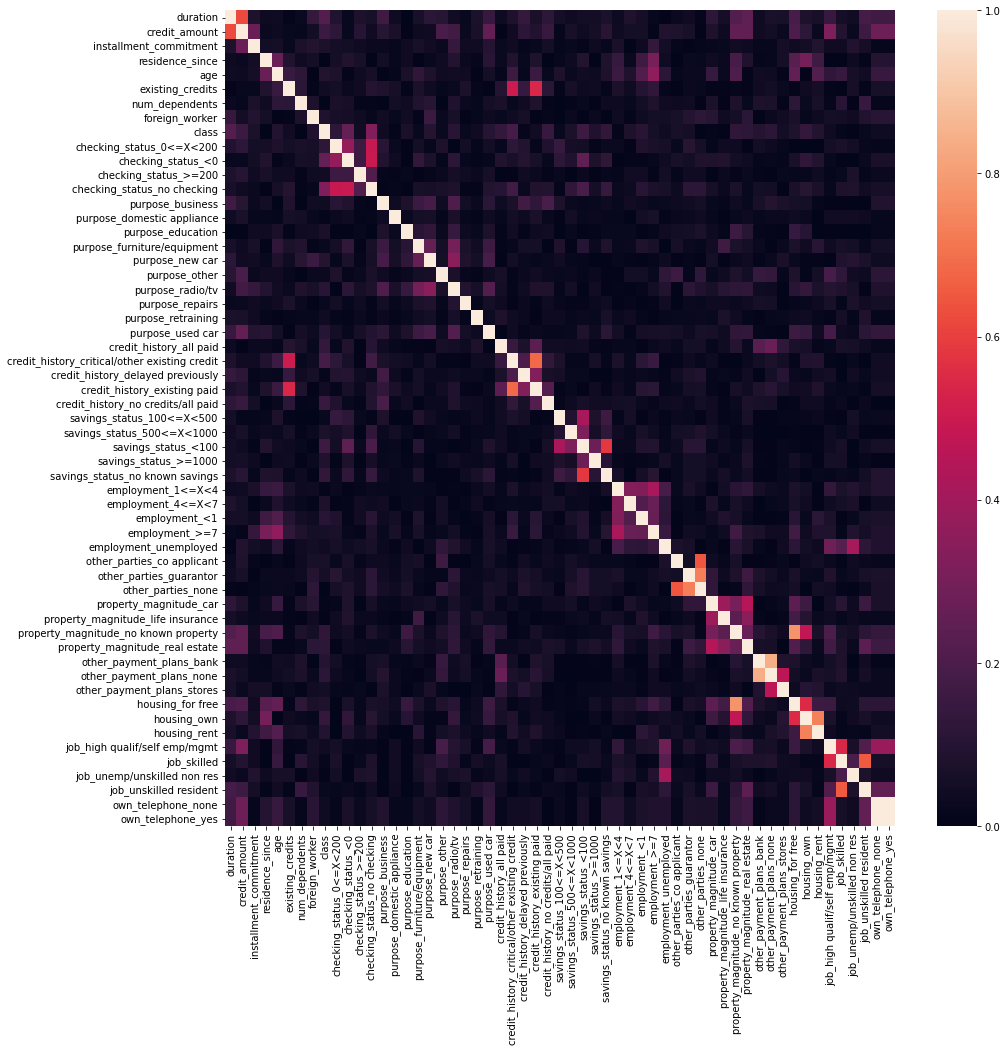

,duration,credit_amount,installment_commitment,personal_status,residence_since,age,existing_credits,num_dependents,foreign_worker,class,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,male single,4,67,2,1,1,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,female div/dep/mar,2,22,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,male single,3,49,1,2,1,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,male single,4,45,1,2,1,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,male single,4,53,2,2,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,female div/dep/mar,4,31,1,1,1,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,male div/sep,4,40,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,male single,4,38,1,1,1,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,male single,4,23,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


In [6]:
import seaborn as sns
from sklearn import datasets

def correlation_between_features(df: pd.DataFrame):
    '''
    Args:
        df: Dataframe of the features
       
    Returns:
       None
    '''

    # Descriptive stats
    display(df.describe())

    # Correlation matrix
    plt.figure(figsize=(15,15))
    correlation_matrix = df.corr().abs()
    sns.heatmap(correlation_matrix)
    plt.show()

    return

# Run simple EDA function...
correlation_between_features(df=df)

df

Imbalamced data can introduced a major bias, particularly when we are fitting a model to a relatively low probability event, such as a default. By definition our target occurs less than half the time.

#### Bias Alert: Imbalanced dataset

Imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain a more equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, default/no default, meaning that ideally 50% of our samples should be class=1; and 50% class=0. If this is not the case and we have an imbalance (we do), we can balance the data by up-sampling the minority class, or down-sampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Dataset Balanced?
0    700
1    300
Name: class, dtype: int64
Imbalanced y variable!


True

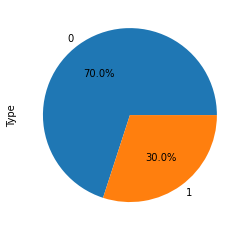

In [7]:
# Imbalanced y classes?
GovernanceUtils.imbalanced_y_check(df['class'])

The dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we train our model, or risk introducing dangerous biases into our forecasts.

#### Bias Alert: Protected and Majority Groups...

Loan approval is a high risk application. We need to go very carefully as a result. We need to identify any protected characteristics (ie it would be illegal to differentiate based on these) present in the dataset. 
Our use-case is a loan approval use case, ethnicity and gender are protected charcteristics where biases would be illegal. We need to remove these features from the model training/prediction process to avoid the model making decisions based on these features. We also need to be aware of other features that proxy protected characteristics, such as zip codes, and remove or adjust them appropriately.


In [8]:
# Check for biases on protected characteristics...
df_female = df_raw[(df_raw['personal_status'].str.contains('female') != 0)]
df_male = df_raw[(df_raw['personal_status'].str.contains('female') == 0)]

# % of females 
female_good_credits = df_female[(df_female['class'] == 'good')].shape[0]
female_good_credits_pct = female_good_credits / df_female.shape[0]
#
male_good_credits = df_male[(df_male['class'] == 'good')].shape[0] 
male_good_credits_pct = male_good_credits / df_male.shape[0]

#  Difference in good credits for females and males...
print('Female good credits: ' + str(format(round(female_good_credits_pct*100, 2))) + '%')
print('Male good credits: ' + str(format(round(male_good_credits_pct*100, 2))) + '%')


Female good credits: 64.84%
Male good credits: 72.32%


Having found some protected characteristics and potential biases, we need to refine the dataset to consider these. 

In [9]:
# Protected characteristics - 'personal_status' has a "gender" classifier - We need to remove this from model training.
df['gender'] = np.where(df['personal_status'].str.contains('female') == 0, 1, 0) #'male'=0; female=1
df = df.drop('personal_status', axis=1)

# Another protected characteristic is age. We can categorise the ages in our dataset... 
df['age'] = df['age'].apply(lambda x: 3 if x > 65 else (2 if x > 25 else 1))

# **********************************************************
# We need to remove these columns from model training, or risk 
# illegal biases in our outcomes... 
# Keep a record of the protected columns
protected_cols = ['gender', 'age']
# **********************************************************

# Stage3: Model Design 

Now we need to take what we have learned about the data, and find an appropriate model to achieve our KPIs.

## Stage 3a: Test the performance of different up, and down sampling approaches

Before we start up or down-sampling to correct the imbalance, we first we need to create our testing and training datasets. We can then balance the training set. This is to keep the training-set in-sample and the testing-set strictly out-of-sample. There is a risk of data leakage in this process we must consider and contriol for.


#### Bias Alert: Data Leakage 

Separate training and testing datasets BEFORE balancing the dataset to avoid data leakage. This is crucial as our learner must not see any of the test samples until we actually test it for performance. If we fail to separate testing and training data before up samplng, we can suffer data-snooping biases (also called data-leakage), which would invalidate our model.

In [10]:
# We will use sklearn throughout this notebook
from sklearn.model_selection import train_test_split

In [11]:
# Prepare the data for balancing... Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

### Stage Test up and down sampling approaches using a Random Forest Classifier
We will use the RandomForest classifier to help us test different up and down sampling approaches to deal with the imbalanced dataset. We will be able to see the relative performance of each balancing approach on our problem.

First let us run the classifier on the imbalanced data and examine the F1 score that results when we test the model. (It is a very poor result).

Get the sklearn packages we will need for our clasification problem

In [12]:
# Normalize/standardize input data
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier

# Performance metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

We can wrap training for the Random Forest classifier, and the printing of performance metrics into a function, as we will need to run this more than once.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.7929, test:  0.7000
Precision train: 0.9649, test:  0.9286
Recall train: 0.2778, test:  0.1275
F1 train: 0.4314, test:  0.2241


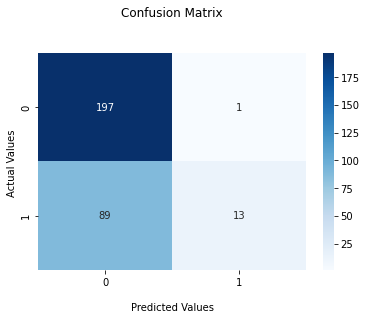

Now use sklearns predict_proba to generate probability values for each prediction
[[0.4042536  0.5957464 ]
 [0.4259768  0.5740232 ]
 [0.45308594 0.54691406]
 [0.62625302 0.37374698]
 [0.66999062 0.33000938]
 [0.68959385 0.31040615]
 [0.45446586 0.54553414]
 [0.42737912 0.57262088]
 [0.47565212 0.52434788]
 [0.44763244 0.55236756]]
[1 1 1 0 0 0 1 1 1 1]


In [13]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_rf_classification_models(X_train: pd.DataFrame, 
                              X_test: pd.DataFrame, 
                              y_train: pd.DataFrame, 
                              y_test: pd.DataFrame) -> object:
    
    '''
    Args:
      X_train: DataFrame with training data for classifier, columns are features, rows are instances
      X_test: Test data matching above shape
      y_train: training data target variable {1,0}, instances are rows.
      y_test: test data target variable {1,0}, instances are rows.
       
    Returns:
       rf: sklearn model object
       
    Author:
       Dan Philps
    '''

    #sanity checks on inputs
    if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if X_test.shape[0] != y_test.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if (X_train.dtypes != X_test.dtypes).sum() != 0:
      raise TypeError('Bad parameter: X_train.dtype != X_test.dtype')
    if (y_train.dtypes != y_test.dtypes):
      raise TypeError('Bad parameter: y_train.dtype != y_test.dtype')

    # Scale and transform the data for training
    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train_cols = X_train.columns
    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    X_train = pd.DataFrame(X_train)
    X_train.columns = X_train_cols

    # classifier train
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Analytics calculated wrt default or y=1... Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.4f}, test: ",
      f"{rf.score(X_test,y_test):.4f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[1]:.4f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[1]:.4f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")
    
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

    #sanity checks on output
    if rf is None:
      raise TypeError('Bad return: rf is None')

    return rf

#run our classifier function
mod = run_rf_classification_models(X_train, X_test, y_train, y_test)

# dump the probability values for each prediction we have just made - we will be using the 
# probability value to determine the lending threshold later
print('Now use sklearns predict_proba to generate probability values for each prediction')
print(mod.predict_proba(X_test)[30:40,:])
print(mod.predict(X_test)[30:40])

Note the F1 score on the test data is low using an imbalanced training dataset. Now we can balance the dataset.

### 3a i) Upsampling using resampling

First we test up-sampling using sklearn's resample, and examine how well it does using the RandomForest classifier. Resampling can up-sample by simply randomly selecting and copying existing observations of the minority class. We can balance the classes in this way.

In [14]:
from sklearn.utils import resample

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples = the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#****************************
# Keep record of protected for bias testing later
X_upsampled_protected = X_upsampled[protected_cols]
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_upsampled = X_upsampled.drop(protected_cols, axis=1)
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Let us check everything is in balance now

Dataset Balanced?
0    485
1    485
Name: class, dtype: int64


False

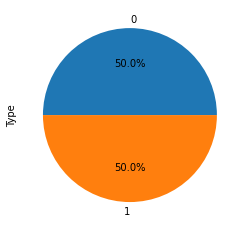

In [15]:
# Imbalanced y classes?
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
GovernanceUtils.imbalanced_y_check(temp['class'])

Dataset is perfectly in balance...

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8289, test:  0.7300
Precision train: 0.8158, test:  0.5156
Recall train: 0.8495, test:  0.7765
F1 train: 0.8323, test:  0.6197


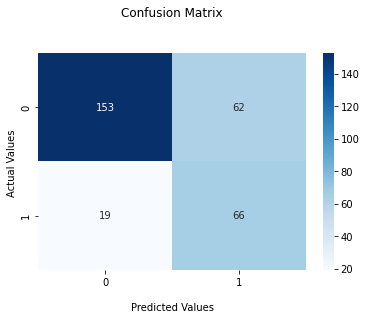

In [16]:
#Run our function....
model = run_rf_classification_models(X_upsampled, X_test, y_upsampled, y_test)

The F1 score on the test data has increased markedly.

### 3a ii) Up-sampling using a synthetic over sampling approach called SMOTE

Add the libraries we will need... and generate the synthetic data to balance our classes using SMOTE.

In [17]:
from imblearn.over_sampling import SMOTE

#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X=X_train, y=y_train)

Before we use the up-sampled dataset to train our classifier, let us first examine the distribution of the synthetic datapoints that SMOTE creates

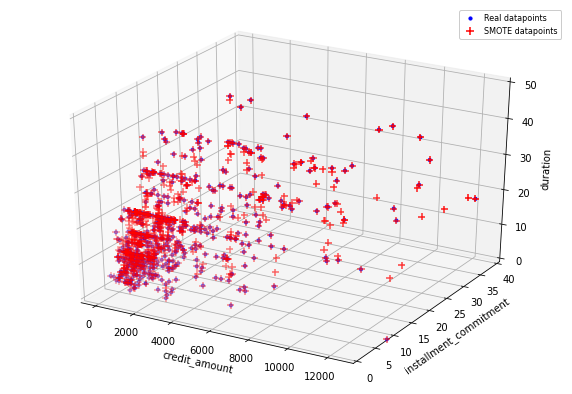

In [18]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['installment_commitment'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['installment_commitment'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
ax.set_xlim(-500, 13000)
ax.set_ylim(0, 40)
ax.set_zlim(0,50)

ax.set_xlabel('credit_amount')
ax.set_ylabel('installment_commitment')
ax.set_zlabel('duration')

plt.title= 'How SMOTE Samples are Distributed vs Real Data Points'
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Dataset Balanced?
0    485
1    485
Name: class, dtype: int64


False

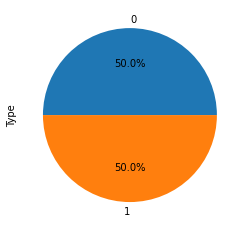

In [19]:
# Imbalanced y classes?
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
GovernanceUtils.imbalanced_y_check(temp['class'])

After up-sampling using SMOTE's synthetic data, the dataset is perfectly in balance...

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8505, test:  0.7367
Precision train: 0.8307, test:  0.5319
Recall train: 0.8804, test:  0.5882
F1 train: 0.8549, test:  0.5587


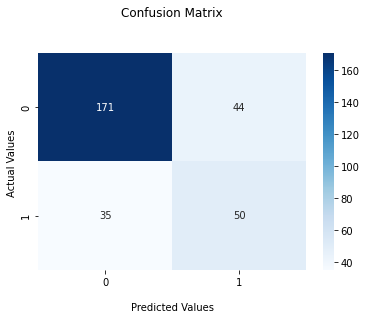

In [20]:
#Run our function....
model = run_rf_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

### 3a iii) Down-sampling - Removing rows to balance the classes

Now we can test down-sampling, which is simply removing samples from the majority class. 

In [21]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Dataset Balanced?
0    211
1    211
Name: class, dtype: int64


False

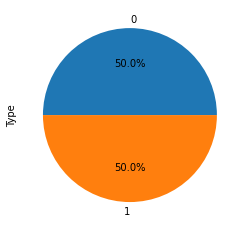

In [22]:
# Imbalanced y classes?
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
GovernanceUtils.imbalanced_y_check(temp['class'])

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8104, test:  0.7167
Precision train: 0.7787, test:  0.5135
Recall train: 0.8673, test:  0.8539
F1 train: 0.8206, test:  0.6414


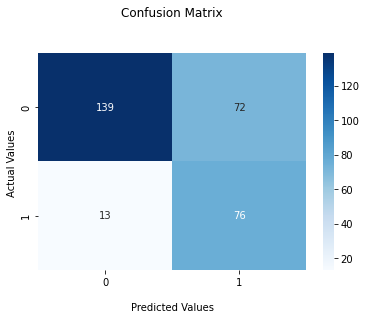

In [23]:
# Run our function to train a rf classifier....
model = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)

As we can see, all up and down sampling approaches have outperformed the F1 Score on the imbalanced data. The most impressive performance in this case is from up-sampling using SMOTE synthetic data.

## Stage 3b: Model Selection


Next we need to select the type of classifier we are going to use to model our problem and separate good from bad credits. We could just make a heuristic selection, but we are likely to be biased in making this selection. 


#### Bias Alert: Availability Heuristic
Model selection is open to bias. For instance, if our quant team overpopulated by linear regression experts, we are prone to choose linear regression. If we have a greater level of familiarity for RF classifiers, we are likely to choose RF.

One way of dealing with this is to use a systematic model selection approach. We can test the problem, using many different classsifiers and assess the performance of each based on our KPIs. However, we must be careful as even this more exhaustive approach is also open to biases.


#### Bias Alert: Multiplicity bias

If we are selecting a model based on p-values, for instance, we might suffer from multiplicity bias where testing multiple approaches would exaggerate the significance of a success. 
To somewhat mitigate this we could select based on a measure such as F1-score, applied to out of sample data. In ML we tend to separate our data into training, testing, and cross-validation. We will use the cross-validation data to select a model type below.

In [24]:
# Get cross-validation set, broken out from training data, to select the classifier
# Objective is to keep the classifier choice "in sample", so that running on the test data 
# will be a true out-of-sample test. No data leakage bias.

# Test and train set    
X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

# Cross validation as a subset of 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

Sklean provides many different classifiers and we will be testing a wide range to determine their performance on our problem to address the biases of the availability heuristic. We will now build a function that tests a number of different classifiers on our problem, and the one with the best F1-score on the cross-validation data, we will select as the "best".

DecisionTreeClassifier(max_depth=5)
Precision train: 0.8046, cross-validation:  0.4124
GaussianNB()
Precision train: 0.8195, cross-validation:  0.6000
LogisticRegression(max_iter=2000, random_state=0)
Precision train: 0.8615, cross-validation:  0.4179
MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
Precision train: 0.6748, cross-validation:  0.4583
RandomForestClassifier(max_depth=3, random_state=0)
Precision train: 0.8113, cross-validation:  0.5806
LinearDiscriminantAnalysis()
Precision train: 0.8789, cross-validation:  0.3986
QuadraticDiscriminantAnalysis()
Precision train: 1.0000, cross-validation:  0.3190


Variables are collinear
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


AdaBoostClassifier()
Precision train: 0.8699, cross-validation:  0.0000


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


GradientBoostingClassifier()
Precision train: 0.9538, cross-validation:  0.5000
KNeighborsClassifier(n_neighbors=3)
Precision train: 0.8039, cross-validation:  0.0000


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


SVC(C=0.025, probability=True)
Precision train: 0.6087, cross-validation:  0.0000


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


NuSVC(probability=True)
Precision train: 0.6505, cross-validation:  0.0000


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Winner
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8064, cross-validation:  0.7286
Precision train: 0.8113, cross-validation:  0.5806
Recall train: 0.8699, cross-validation:  0.5373
F1 train: 0.8396, cross-validation:  0.5581


X has feature names, but RandomForestClassifier was fitted without feature names


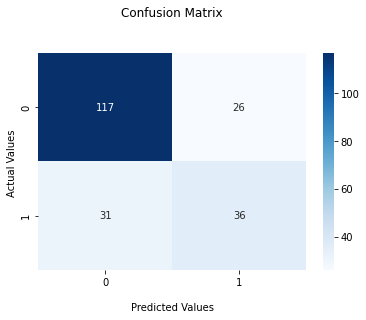

In [25]:
# Run our function....autoselect the best classifier wrt F1
max_mdl, all_models, all_models_desc, all_mdls_prec = GovernanceUtils.auto_classifier_selection(X_train_cv, X_cv, y_train_cv, y_cv, 'f1')


The output from our model selection function shows how each classifier performed on the training and cross-validation datasets. We can now test the "winning classifier" on our test data to ensure the cross-validation tests are effective out of sample.

0.5714285714285714


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but RandomForestClassifier was fitted without feature names


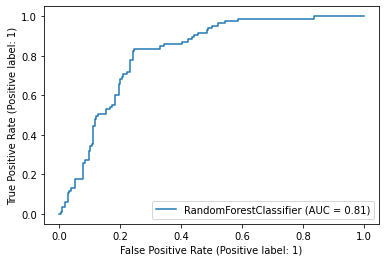

0.6315789473684211 0.5714285714285714 0.7058823529411765


In [26]:
# Predict
y_test_hat = max_mdl.predict(X_test.values)

# Analyst KPI...
f1, prec, rec = StakeholderKPIReporting.kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test[:].values, y_hat=y_test_hat[:])
print(f1, prec, rec)

#### Bias Alert: Inductive bias

Even in the case where we select the most appropriate model, we may still be exposed to inductive biases. Each learner has a specific way of approximate our function, in this case the function of credit quality based on the characteristics of borrowers. Decision Trees, for instance, have inductive biases associated with greedy separation, whereas Random Forests (RF) mitigate this bias by using many randomized decision trees, but in turn introduce (lesser) inductive biases associated with the way an RF's underlying decision trees are contructed. One mitigant is to ensemble different learners, using a soft-max function or a voting approach. For voting based ensembling we would simply run a number of classifiers, take the majority answer: good/bad credit. The risk is that by introducing poorer peforming learners (we rejected in the model selection process because they had a low F1 score) we may reduce the reliance of our process on a single learner, but we could also damage our outcomes. We run such an ensemble below.


Variables are collinear
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature name

0.71875


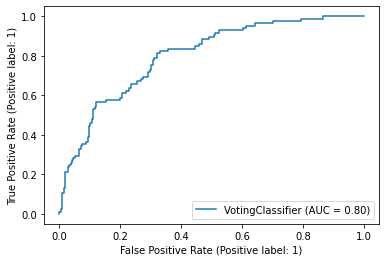

0.39316239316239315 0.71875 0.27058823529411763


In [27]:

# Run an ensemble of selected learners
y_test_hat, ens_mdl = GovernanceUtils.challenger_ensemble_run(all_mdls=all_models,
                        all_mdls_desc=all_models_desc,
                        all_mdls_prec=all_mdls_prec,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test)

# Analyst KPI...
f1, prec, rec = StakeholderKPIReporting.kpi_review_analyst(mdl=ens_mdl,X=X_test, y=y_test[:], y_hat=y_test_hat[:])
print(f1, prec, rec)

Ensembling tends to produce more robust ourcomes but may in some cases damage performance.

## Stage 3c: Fairness

We need to ensure that loan decisions are fair across different groups in the population as well as achieving the lender's KPIs.

We will execute the following steps:
* Review fairness of our model overall, regarding specific groups
* Test lending thresholds for fairness, first a conservative one (0.9), then a more aggressive one (0.5)
* Find optimium threshold: Finally we will search for the optimium threshold, that achieves the lender KPIs best, at the same time remaining fair within our tolerances.

### Stage 3c i): High level fairness checks for model

In [28]:
X_test_protected

,gender,age
355,1,1
374,0,2
179,1,2
561,1,1
574,1,2
...,...,...
60,1,2
250,0,2
240,0,2
27,0,2


### Stage 3c ii): Fairness checks for specific lending thresholds

In [29]:
X_test_gender = pd.Series(X_test_protected['gender'].apply(lambda x: 'male' if x==1 else 'female'))

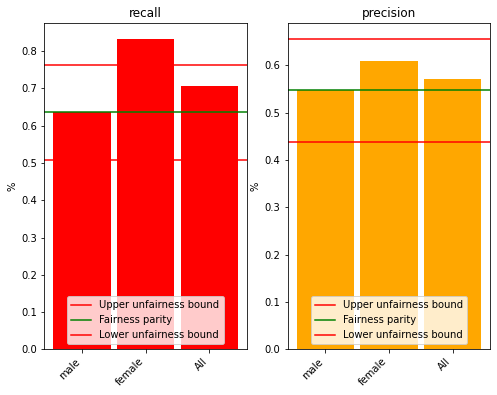

In [30]:
# Test a 0.5 threshold for fairness...
df_stats = FairnessUtils.fairness_stats_get (mod=max_mdl, 
                               X_test=X_test, 
                               y_test=y_test, 
                               X_test_category_col=X_test_gender, 
                               y_approval_threshold=0.5)

FairnessUtils.plot_fairness_charts(df_stats, "male", "recall", "precision")

In the above example, it is seen that using a threshold of 0.5, the model is not seen fair - the recall value Females is outside of the 20% rane from the recall value for Males, indicating that the decision makes females worse off compared to Males. Now let us try to run the model with a threshold of 0.9, i.e. the model outcome should have a probabiity exceeding 0.9 to accept a specific response.  In this case, it is seen that the model is fair and has a high recall, while the precision is low.

invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars


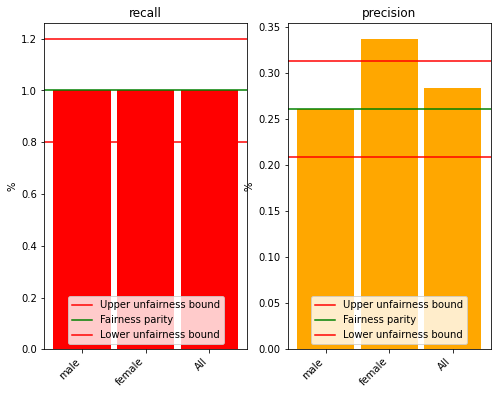

In [31]:
# Test a 0.9 threshold for fairness...
df_stats = FairnessUtils.fairness_stats_get (mod=max_mdl, 
                               X_test=X_test.copy(deep=True), 
                               y_test=y_test.copy(deep=True), 
                               X_test_category_col=pd.Series(X_test_gender).copy(deep=True), 
                               y_approval_threshold=0.9)

FairnessUtils.plot_fairness_charts(df_stats, "male", "recall", "precision")

### Stage 3c iii): Optimum Lender KPIs while achieving Fairness...


Utilize the process process defined earlier to identify an appropriate model in this context by reviewing recall values that are within acceptable limits for different population groups, concurrently maximizing the overall model precision. 

invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in long_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division

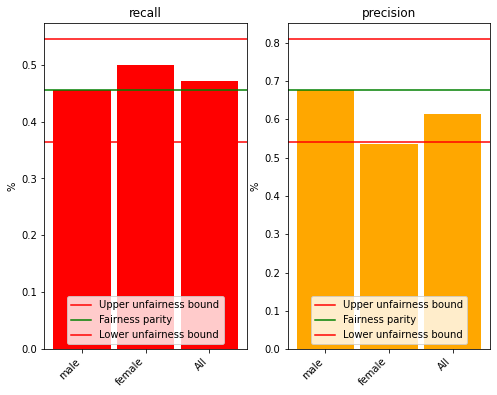

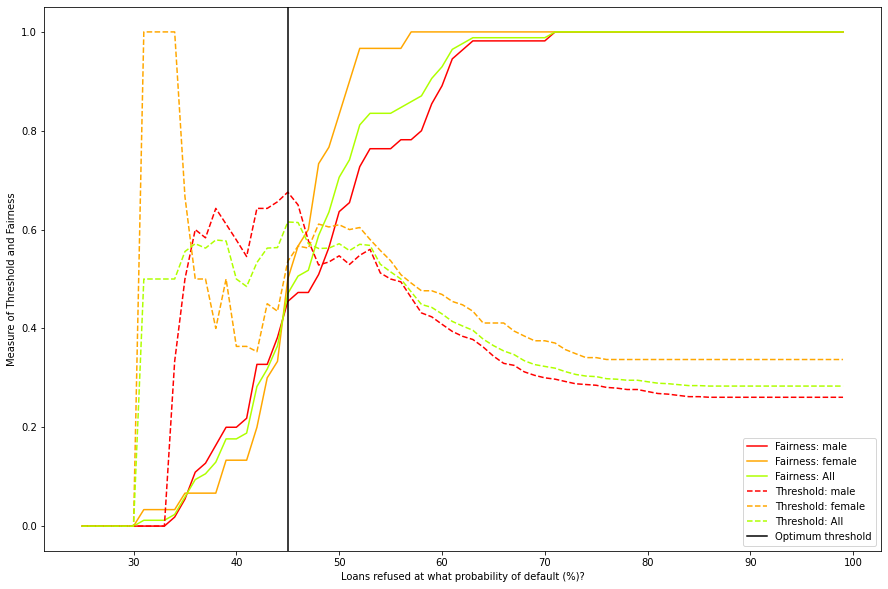

Optimal threshold: 0.45


In [32]:
# Get the optimal threhold to use, by iterating with different values of threshold, that determines the model outcomes.
optimal_threshold = FairnessUtils.decision_threshold_find_optimal(max_mdl, X_test, y_test, X_test_gender)

The threshold that maximizes business KPI, while avoiding bias in the classes monitored is ...

In [33]:
optimal_threshold

0.45

# Stage4: Model Deployment 

Model deployment generally involves a change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of thius stage is communication of the KPIs to stakleholders to enable them to understand the way the models operate, the risks involved and to be accountable for deploying the models


## Stage4a. KPIs

We have already tested our models for the most important KPIs ... check. 

## Stage4b. Communication: Stakeholder Oriented Explanations

Communication of how the model has reached the outcomes it is has, is crutial to achieve fairness, transparency, accountability, and trust in the whole process. Each stakeholder in the process needs to see different elements. The Data Scientist and technical leadership need to review the nut and bolts of the model, reviewing residuals plots, parameter importance, interaction terms and many other metrics. The customer needs to see far less information, and mainly that associated with a refusal of credit. Compliance resources and regulators need to see something different again, such as fairness regarding protected characteristics, the accuracy and therefore capital risk represented by the models. 
In this section we look at stakeholder oriented explanations and we will be using standard charts of important analytics, such as residual plots, and SHAP.


Now instantiate the SHAP explainer object for our classifier and generate Shapley values for the test data... Note that as we will be using the test data, all the analysis is therefore based on the out of sample performance of our model.

In [77]:
shap_values, expl, X_test_reduced, X_test_protected_reduced = classifier_shap_vals(max_mdl=max_mdl, 
                                                                                  X_test=X_test,                                                                                      
                                                                                  X_test_protected=X_test_gender)

### 1) Analyst and technical explainability

0.71875


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but KNeighborsClassifier was fitted without feature names


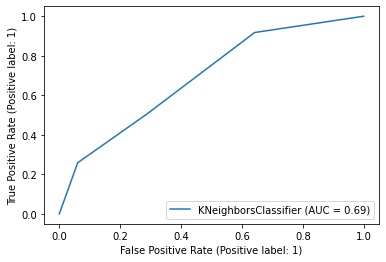

(0.39316239316239315, 0.71875, 0.27058823529411763)

In [41]:
# Analyst KPI...
StakeholderKPIReporting.kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test, y_hat=y_test_hat)

Feature importance

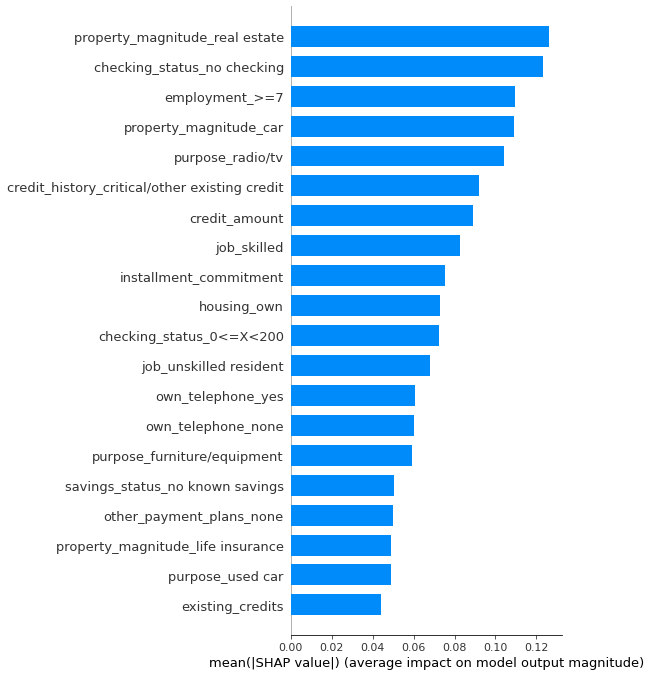

In [78]:
# Plot the feature importance
plt.set_title = "Feature Importance: Credit-Use Case Feature Importance"
shap.summary_plot(shap_values, X_test_reduced, feature_names=list(X_test_reduced.columns.values), plot_type='bar', show=False)
plt.show()

Beeswarm plot, showing features ranking by importance, and the impact of each instance passed to the shap explainer. Note the feature value is color coded from "high" to "low" (vertical axis), and the Shap value represents the impact on the model output of the value (horixontal axis). 

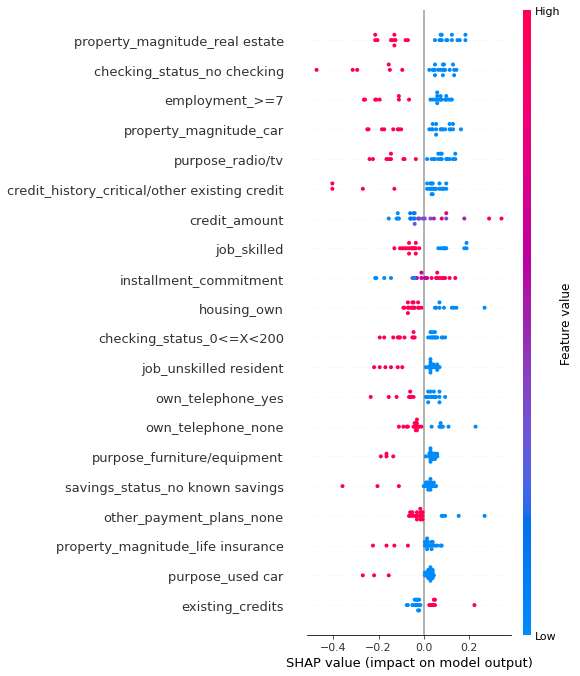

In [79]:
shap.summary_plot(shap_values, X_test_reduced, show=False)
plt.set_title = "Beeswarm: Credit-Use Case Feature Importance and Dependency"
plt.show()

### 2) Compliance and Regulatory



Qualitatively check to see if any features are suspiciously important for one (eg) gender vs another.

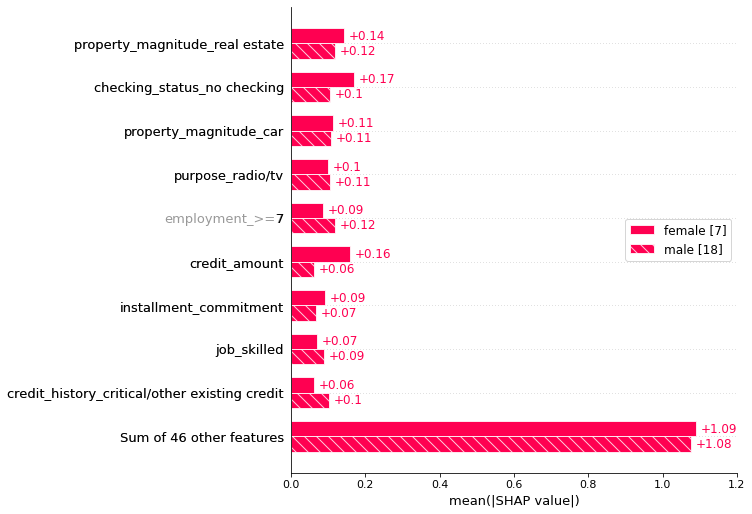

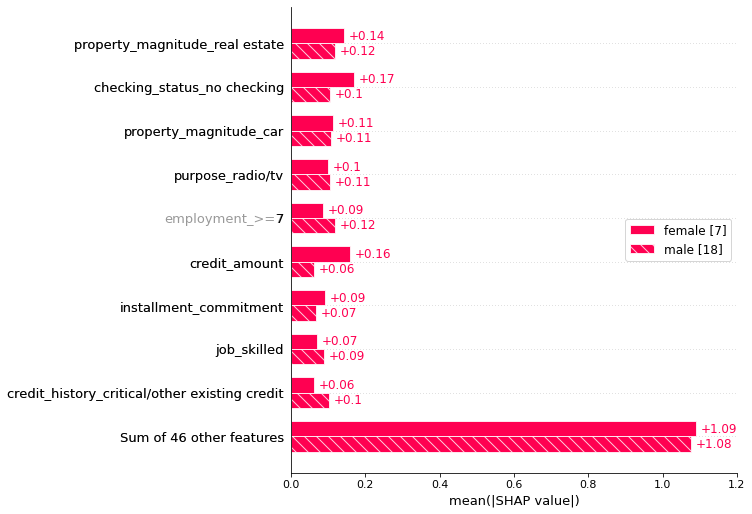

In [80]:
# Some learners do not have direct support from shap. 
try:
  # Feature importance by protected characteristic.. different treatment?
  for prot_char in X_test_protected.columns:
    # Extract the protected classes.
    if type(X_test_protected_reduced) == pd.Series:
      curr_prot_cats = X_test_protected_reduced.values 
    else:
      X_test_protected_reduced[prot_char].astype(str).to_list() 

    # Plot the feature importance
    shap.plots.bar(shap_values.cohorts(curr_prot_cats).abs.mean(0), show=False)
    
    plt.title= "Bias Check: Feature Importance of protected group: " + prot_char
    plt.show()
except:
  print('SHAP values do not allow cohort separation for ' + str(type(max_mdl)))

Threshold to determine loan acceptances, and fairness of those acceptances for our model...

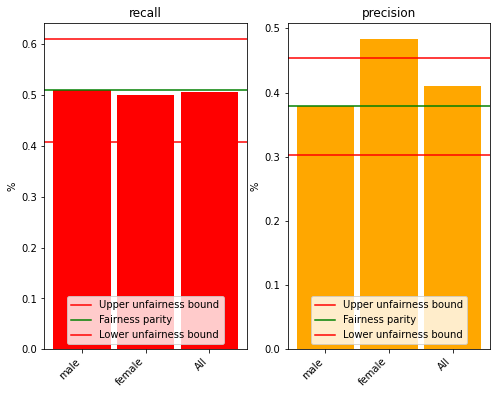

In [57]:
# Test our optimum threshold
df_stats = FairnessUtils.fairness_stats_get(max_mdl, X_test, y_test, X_test_gender, optimal_threshold)

FairnessUtils.plot_fairness_charts(df_stats, "male", "recall", "precision")

### 3) Customer

A customer may want to knowlt he sensitivity of the decision to certain characteristics. IF a refusal has been made, it would be beneficial to report to the customer what they need to change to get a favorable outcome. 

We can use the SHAP waterfall plot to help

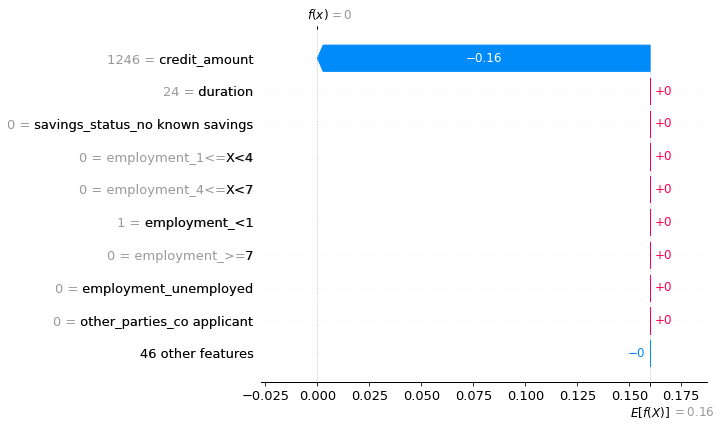

In [65]:
# Find a customer with bad credit prediction
for rejected_eg_rowno in range(0,y_test.shape[0]):
  if y_test.iloc[rejected_eg_rowno] == 1:
    break

# This customer was refused credit and we can provide an explanation for their refusal...
try:
  shap.plots.waterfall(shap_values[rejected_eg_rowno])
except:
  print('Shap charts of this type are not supported for ' + str(type(max_mdl)))

# Stage 5: Model Monitoring and Reporting



Our model is now in production and being used in practice. We are "risk on" and we need to continually monitor and record our KPIs. Individuals accountability for these processes is critical.

We also need to monitor data drift. If the distribution or the nature of the data we pass into our model substantioally differs from our training data, our model results will almost certainly be garbage. We need to monitor data drift and should drift occurr we need to re-run our model developmnent process to traing an appropriate model. This would take us back to Stage2 in this process.

There is also the question of whether our model is still the best approach as time steps forward? Our model paramaters may become stale, the model itself may be less appropriaytr given its inductive biases. Many things can change and to monitor this we should consider using a challenger model. Challenger models are used to compete against our live model, and we should monitor our KPIs generated by our live model and compare them to those produced by the challenger model. 

## Stage5a: Data Drift

As a test of how to perform an analysis of data drift let us compare the build data distribution of feature or target values vs. the test data distribtuion of feature or target values. However, once in production you would comapare the distribution at periodic times, typically monthly, to a baseline value, or to prior month to pick up any trends in the featur or target distribution shifting.

To demonstrate how this is done we can test PSI, for the training target and the test target, y_train, y_test. 
If this results in a greater than 0.20 difference than we should investigate the features, or variables, using a
similar test to see which features are responsible for the drift in the target, by looking at X_train vs. X_test.

However, even if the target variable PSi is not breaching, it is always good to keep track of the features to see if
there is a change in the distribution, which may require a recalibration of the model.


In [ ]:
# PRepare train and test data for data drift check
train_datadrift = pd.concat([X_train, y_train], axis=1)
test_datadrift = pd.concat([X_test, y_test], axis=1)

# Data drift check...
data_drift_features = GovernanceUtils.data_drift_psi(train_datadrift,test_datadrift,buckettype='bins',buckets=10,axis=1,single_variable=False)
data_drift_target = data_drift_features[-1]

# Print out the target PSI value:
print("Target PSI value is ",data_drift_target, "\n" )

# Print out the features CSI values
print("The feature CSI values are:")
columns_features = train_datadrift.columns
index_value = 0
for x in columns_features:
  if data_drift_features[index_value] > 0.2:
          print(x, "*************** CSI value is over 0.2 = ",data_drift_features[index_value])
  elif data_drift_features[index_value] > 0.1:
          print(x, "*************** CSI value is over 0.1 = ",data_drift_features[index_value])
  else:
          print(x, "CSI is OK = ",data_drift_features[index_value])
  index_value = index_value + 1


## Stage5b: Challenger Models

So what model do we use as a challenger, and when do we traing it? There are no perfect answers but we can use our model development pipeline to help. Note that our model selection function, auto_classifier_selection, allowed us to generate a range of classifiers, we can use one or all of these classifiers as our challenger. If we decided to ensemble the classifiers as our live model (ir combine the results of all in a voting ensemble for instance) we can select the best single model as our challeger. If we decided to use the best single model as our live model, we can use a boting ensemble as our challenger.



In [ ]:
# Run the challenger ensemble
y_test_hat, ens_mdl = GovernanceUtils.challenger_ensemble_run(all_mdls=all_models,
                        all_mdls_desc=all_models_desc,
                        all_mdls_prec=all_mdls_prec,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test)

# Do we need to retrain the live model?
challenger_check_warning = GovernanceUtils.challenger_review_live(live_mod=max_mdl, challenger_mod=ens_mdl, X_test=X_test, y_test=y_test)

In [ ]:
# Not we see if there are any warnings to do with the performance of our live model versus the Challenger model: 
# ... '' means ... no warnings
challenger_check_warning

# Afterword

We have done our best to include the key themes of what we think are the critical stages of model development in this notebook, but clearly in practice many more checks and details would be added to each of the 5 model development stages to best ensure stakeholders KPIs are met, and Governance standards would be as high as possible. Hopefully our example and key themes will provide insight to avioid many of the classic biases in model development.